In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='NONE' 
SS_VER='SS_VER_1_1'

In [79]:
# Adapt this to your ChipWhisperer installation
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.adc.samples                        changed from 600                       to 5000                     


In [101]:
GADGET = "Refresh"  # possible values are ["AB", "BA", "AND", "ADD", "ZERO"]
ARCH = 'asm' # possible values are ["c", "asm", "naive_asm"]

if ARCH == 'asm':
    samples = {"AB": 1600, "BA": 600, "AND": 900, "OR_": 1200, "ADD": 1100, "Refresh": 400}
elif ARCH == 'naive_asm':
    samples = {"AB": 600, "BA": 300, "AND": 300, "ADD": 700, "ZERO": 600}
elif ARCH == 'c':
    samples = {"AB": 500, "BA": 200, "AND": 300, "ADD": 500, "ZERO": 500}

randomness = {"AB":2, "BA": 2, "AND": 2, "OR_": 2, "ADD": 6, "Refresh": 2}
RAND = randomness[GADGET]
scope.adc.samples = samples[GADGET]

In [102]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" "$GADGET" "$ARCH" "$RAND"
cd target
make clean PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 GADGET=$4 ARCH=$5 RAND=$6 -j

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
rm -f -- Refresh-CW308_CC2538.hex Refresh-CW301_AVR.hex Refresh-CW303.hex Refresh-CW304.hex Refresh-CW308_MEGARF.hex Refresh-CW308_SAM4L.hex Refresh-CW308_STM32F0.hex Refresh-CW308_STM32F1.hex Refresh-CW308_STM32F2.hex Refresh-CW308_STM32F3.hex Refresh-CW308_STM32F4.hex Refresh-CW308_K24F.hex Refresh-CW308_NRF52.hex Refresh-CW308_AURIX.hex Refresh-CW308_SAML11.hex Refresh-CW308_EFM32TG11B.hex Refresh-CWLITEARM.hex Refresh-CWLITEXMEGA.hex Refresh-CWNANO.hex Refresh-CWHUSKY.hex Refresh-CW308_K82F.hex Refresh-CW308_PSOC62.hex Refresh-CW308_IMXRT1062.hex Refresh-CW308_FE310.hex Refresh-CW308_EFR32MG21A.hex Refresh-CW308_EFM32GG11.hex Refresh-CW308_STM32L5.hex Refresh-CW308_NEORV32.hex Refresh-CW312_SAM4S.hex Refresh-CW305_IBEX.hex
.
rm -rf .dep
Cleaning project:
rm -f -- Refresh-CW308_CC2538.eep Refresh-CW301_AVR.eep Refresh-CW303.eep Refresh-CW304.eep Refresh-CW308_MEGARF.eep Refresh-CW308_SAM4L.eep Refresh-CW308_STM32F0.eep Refresh-CW308_

In [103]:
cw.program_target(scope, prog, "target/Refresh-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 10723 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 10723 bytes


In [104]:
from random import randint
from tqdm.notebook import trange
from secrets import randbits
import numpy as np

def get_traces(N):
    traces_1 = []
    traces_2 = []
    x = []
    FIXED = 42
    
    for i in trange(N, desc='Capturing traces'):
        scope.arm()

        mask = randbits(32)
        x0 = FIXED ^ mask
        x1 = mask

        x0_0 = x0 % (2**8)
        x0_1 = (x0 % (2**16)) >> 8
        x0_2 = (x0 % (2**24)) >> 16
        x0_3 = x0 >> 24

        x1_0 = x1 % (2**8)
        x1_1 = (x1 % (2**16)) >> 8
        x1_2 = (x1 % (2**24)) >> 16
        x1_3 = x1 >> 24
        
        fixed_text = bytearray([x0_0, x0_1, x0_2, x0_3, x1_0, x1_1, x1_2, x1_3])

        randomness = bytearray([randbits(8), randbits(8), randbits(8), randbits(8)])
        fixed_text.extend(randomness)
            
        if randbits(1):
            val = (x0 ^ x1)

            target.simpleserial_write('p', fixed_text)
             
            ret = scope.capture()
            t = scope.adc.trig_count
            if ret:
                print("Target timed out!")
            response = target.simpleserial_read('r', 4)
            traces_1.append(scope.get_last_trace())
        else:
            text = bytearray([randbits(8) for _ in range(len(fixed_text))])

            rnd_x0 = (text[3] << 24) |(text[2] << 16) | (text[1] << 8) | text[0]
            rnd_x1 = (text[7] << 24) |(text[6] << 16) | (text[5] << 8) | text[4]
            
            val = (rnd_x0 ^ rnd_x1) 
    
            target.simpleserial_write('p', text)
            ret = scope.capture()
            if ret:
                print("Target timed out!")
            response = target.simpleserial_read('r', 4)
            traces_2.append(scope.get_last_trace())
 
        if VERBOSE:
            print(val == (int(response[3])<<24) + (int(response[2])<<16) + (int(response[1])<<8) + int(response[0]))
            
    size = min(len(traces_1), len(traces_2))
    
    print("Trigger up for", t, "ADC cycles")
    return (traces_1[:size], traces_2[:size], x)

In [108]:
load = 0
if load == 0:
    VERBOSE = False
    nb_traces = 100000
    traces_1, traces_2, x = get_traces(nb_traces)
    traces_1_arr = np.array(traces_1)
    traces_2_arr = np.array(traces_2)
    np.save('traces_1.npy', traces_1_arr)
    np.save('traces_2.npy', traces_2_arr)
else:
    traces_1 = np.load('traces_1.npy')
    traces_2 = np.load('traces_2.npy')

Capturing traces:   0%|          | 0/100000 [00:00<?, ?it/s]

Trigger up for 340 ADC cycles


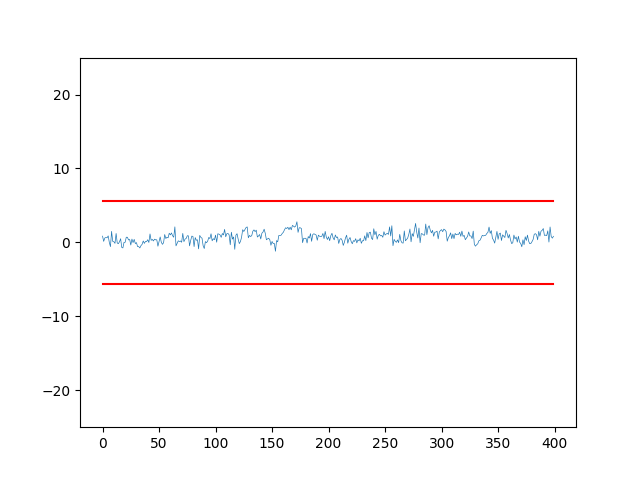

In [112]:
%matplotlib ipympl
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 10**(-5) # error rate
sigma = 1 - (1 - alpha)**(1/samples[GADGET])
th = norm.ppf(1 - sigma/2) # we adapt the threshold depending on number of samples

t_val = ttest_ind(traces_1, traces_2, axis=0, equal_var=False)[0]
plt.close()
plt.plot(t_val[0:], linewidth=0.5)
plt.plot([th]*scope.adc.samples, color = 'r')
plt.plot([-th]*scope.adc.samples, color = 'r')
plt.ylim(-25, 25)
plt.show()

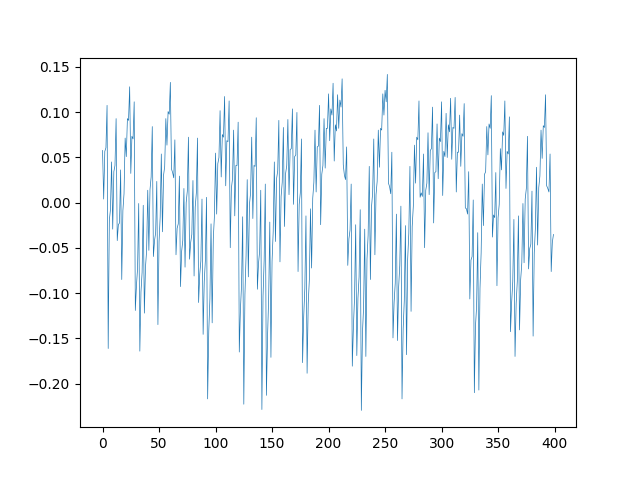

In [114]:
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.close()
for t in traces_1[:1]:
    plt.plot(t[:], linewidth=0.5)
plt.show()

In [19]:
import numpy as np
np.save("t-test-{}-{}-{}.npy".format(str(nb_traces), GADGET, ARCH), t_val)

In [113]:
target.dis()
scope.dis()

True